In [ ]:
!pip install easyocr
!pip install imutils

     |████████████████████████████████| 62.4MB 47kB/s 


In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [ ]:
%cd /content/gdrive/My Drive/Licenta/ColabStorage
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls

/content/gdrive/My Drive/Licenta/ColabStorage
backup					    img_4k_3.jpg
black_white.jpg				    img_4k.png
coco.names				    KNN_training
corrected_license_plate.jpeg		    obj.data
darknet					    obj.names
data					    obj.zip
ExtractedImgForLPR1.png			    OCR
ExtractedImgForLPR2.png			    porche.jpg
ExtractedImgForLPR3.png			    try3.jpeg
ExtractedImgForLPR4.png			    try4.jpeg
generate_train.py			    unnamed.jpg
haarcascade_licence_plate_rus_16stages.xml  yolov3_custom.cfg
haarcascade_russian_plate_number.xml	    yolov3_LPR.cfg
img_4k_2.jpg				    yolov3_LPR.weights


In [ ]:
!cp /mydrive/Licenta/ColabStorage/OCR/coco.names .
!cp /mydrive/Licenta/ColabStorage/OCR/yolov3_LPR.cfg  .
!cp /mydrive/Licenta/ColabStorage/OCR/yolov3_LPR.weights  .

In [ ]:

whT = 320

classesFile = 'coco.names'
classNames = []

#confidence threshhold
confThreshHold = 0.5

# the higher, the agressive and less number of bounding boxes
nmsThreshHold = 0.6

In [ ]:
!ls .

backup					    img_4k_3.jpg
black_white.jpg				    img_4k.png
coco.names				    KNN_training
corrected_license_plate.jpeg		    obj.data
darknet					    obj.names
data					    obj.zip
ExtractedImgForLPR1.png			    OCR
ExtractedImgForLPR2.png			    porche.jpg
ExtractedImgForLPR3.png			    try3.jpeg
ExtractedImgForLPR4.png			    try4.jpeg
generate_train.py			    unnamed.jpg
haarcascade_licence_plate_rus_16stages.xml  yolov3_custom.cfg
haarcascade_russian_plate_number.xml	    yolov3_LPR.cfg
img_4k_2.jpg				    yolov3_LPR.weights


In [ ]:
# read file with classes that yolov3 recognizes
with open(classesFile, 'rt') as f:
    classNames = f.read().rstrip('\n').split('\n')

# read the conf file and weights of yolov3
modelConfiguration = 'yolov3_LPR.cfg'
modelWeights = 'yolov3_LPR.weights'

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)    

In [ ]:
%cd KNN_training

/content/gdrive/My Drive/Licenta/ColabStorage/KNN_training


In [ ]:
img = cv2.imread('ExtractedImgForLPR1002.png')
original_img = img.copy()

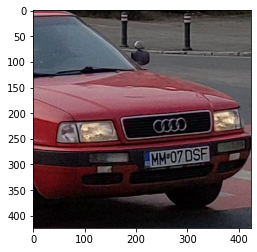

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:

blob = cv2.dnn.blobFromImage(img, 1/255, (whT, whT), [0,0,0], 1, crop = False)
net.setInput(blob)

layerNames = net.getLayerNames()
# print(layerNames)
net.getUnconnectedOutLayers()
outputNames = [layerNames[i[0]-1] for i in net.getUnconnectedOutLayers()]

# get the output of the 3 layers. Outputs is a list

outputs = net.forward(outputNames)

In [ ]:
#find objects in picture
hT, wT, cT = img.shape
# list with x,y,w,h
bbox = []
classIds = []
# confidence values
confs = []
for output in outputs:
    for det in output:
        scores = det[5:]
        classId = np.argmax(scores)
        confidence = scores[classId]
        if confidence > confThreshHold:
            w, h = int(det[2] * wT), int(det[3] * hT)
            x, y = int(det[0] * wT - w/2), int(det[1] * hT - h/2)
            bbox.append([x,y,w,h])
            classIds.append(classId)
            confs.append(float(confidence))

indices = cv2.dnn.NMSBoxes(bbox, confs, confThreshHold, nmsThreshHold)

x, y, w, h = 0, 0, 0, 0

for i in indices:
    i = i[0]
    box = bbox[i]
    x, y, w, h = box[0], box[1], box[2], box[3]
    cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(img, f'{classNames[classIds[i]].upper()} {int(confs[i] * 100)}%' , (x, y-10), cv2.FONT_HERSHEY_COMPLEX, 0.6, (0,255,0), 2)
    break



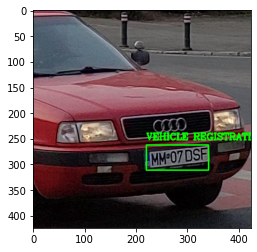

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
cropped_image = original_img[y-5:y+h, x:x+w+5]

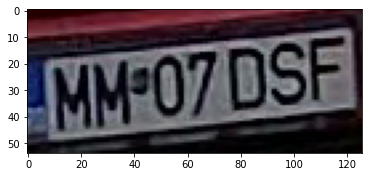

In [ ]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

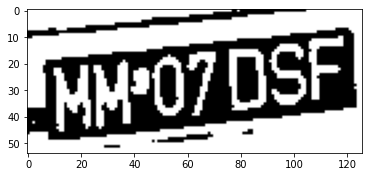

In [ ]:
gr = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
th = 255 - cv2.threshold(gr, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
thresh = cv2.threshold(gr, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# Blur and perform text extraction
# th = cv2.GaussianBlur(th, (3,3), 0)
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))

[INFO] keeping connected component '4'
[INFO] keeping connected component '5'
[INFO] keeping connected component '6'
[INFO] keeping connected component '7'
[INFO] keeping connected component '8'
[INFO] keeping connected component '9'
[INFO] keeping connected component '10'


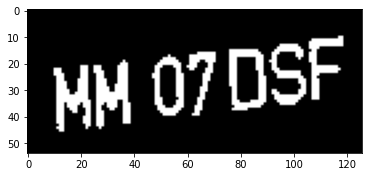

In [ ]:
connectivity = 4
#labeling connected components
output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output

mask = np.zeros(gr.shape, dtype="uint8")

for i in range(1, numLabels):
  # extract the connected component statistics for the current
  # label
  x = stats[i, cv2.CC_STAT_LEFT]
  y = stats[i, cv2.CC_STAT_TOP]
  w = stats[i, cv2.CC_STAT_WIDTH]
  h = stats[i, cv2.CC_STAT_HEIGHT]
  area = stats[i, cv2.CC_STAT_AREA]
  # ensure the width, height, and area are all neither too small
  # nor too big
  keepWidth = w > 1 and w < 30
  keepHeight = h > 20 and h < 50 #or h>10
  keepArea = area > 30 and area < 320
  # ensure the connected component we are examining passes all
  # three tests
  if all((keepWidth, keepHeight, keepArea)):
    # construct a mask for the current connected component and
    # then take the bitwise OR with the mask
    print("[INFO] keeping connected component '{}'".format(i))
    componentMask = (labels == i).astype("uint8") * 255
    mask = cv2.bitwise_or(mask, componentMask)
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

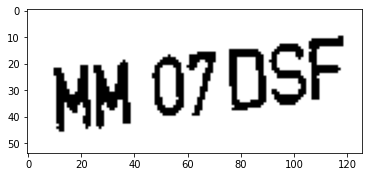

In [ ]:
KNN_export = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(cv2.cvtColor(KNN_export, cv2.COLOR_BGR2RGB))

In [ ]:
from random import randrange
cv2.imwrite("exportedLicensePlate" + str(randrange(10000)) + ".jpg", KNN_export)

True

In [ ]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

[([[9, 7], [129, 7], [129, 47], [9, 47]], 'MM17 SMM', 0.23843958653654876)]

In [ ]:
# load modified image and see how easyOCR does on that one
corrected_license_plate = cv2.imread('corrected_license_plate.jpeg')
plt.imshow(cv2.cvtColor(corrected_license_plate, cv2.COLOR_BGR2RGB))

error: ignored

In [ ]:
reader = easyocr.Reader(['en'])
result = reader.readtext(corrected_license_plate)
result

[([[77, 219], [169, 219], [169, 315], [77, 315]], 'n0', 0.16976171735379),
 ([[144, 67], [1029, 67], [1029, 340], [144, 340]],
  'MM77 DRU',
  0.20665606799851843)]

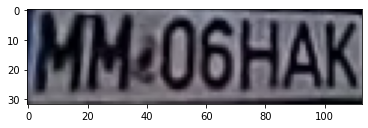

In [ ]:
# NOW TRY THIS WITH IMAGE WARP PERSPECTIVE

# targeted rectangle on original image which needs to be transformed
tl = [10, 10]
tr = [110, 0]
br = [110, 28]
bl = [13, 32]

corner_points_array = np.float32([tl,tr,br,bl])

# original image dimensions
width = cropped_image.shape[1]
height = cropped_image.shape[0]

# Create an array with the parameters (the dimensions) required to build the matrix
imgTl = [0,0]
imgTr = [width,0]
imgBr = [width,height]
imgBl = [0,height]
img_params = np.float32([imgTl,imgTr,imgBr,imgBl])

# Compute and return the transformation matrix
matrix = cv2.getPerspectiveTransform(corner_points_array,img_params)
img_transformed = cv2.warpPerspective(cropped_image,matrix,(width,height))
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))

In [ ]:
reader = easyocr.Reader(['en'])
result = reader.readtext(img_transformed)
result

[]

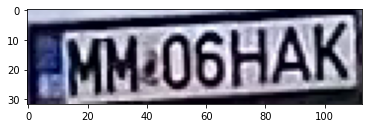

In [ ]:
alpha = 1.6 # Simple contrast control
beta = 0    # Simple brightness control
new_image = np.zeros(cropped_image.shape, cropped_image.dtype)
for y in range(cropped_image.shape[0]):
    for x in range(cropped_image.shape[1]):
        for c in range(cropped_image.shape[2]):
            new_image[y,x,c] = np.clip(alpha*cropped_image[y,x,c] + beta, 0, 255)



plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [ ]:
reader = easyocr.Reader(['en'])
result = reader.readtext(new_image)
result

[([[7, 0], [113, 0], [113, 32], [7, 32]], 'MMOGHAK', 0.3212166425599435)]

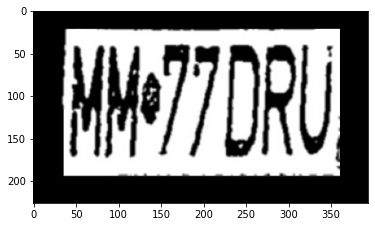

In [ ]:
# load clean image and try easyOCR
clean_img = cv2.imread('black_white.jpg')
plt.imshow(cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB))

In [ ]:
result = reader.readtext(img_transformed)
result

[([[0, 2], [270, 2], [270, 138], [0, 138]], 'Mlili', 0.029737314209342003)]

In [ ]:
!pip install pytesseract
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'
!apt-get update
!apt-get install libleptonica-dev 
!apt-get install tesseract-ocr tesseract-ocr-dev
!apt-get install libtesseract-dev
!pip install tesseract
!pip install tesseract-ocr
!sudo apt install tesseract-ocr


Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

In [ ]:
	def build_tesseract_options(psm=7):
		# tell Tesseract to only OCR alphanumeric characters
		alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
		options = "-c tessedit_char_whitelist={}".format(alphanumeric)
		# set the PSM mode
		options += " --psm {}".format(psm)
		# return the built options string
		return options

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[0, 2], [270, 2], [270, 139], [0, 139]], 'Mili', 0.0034230686724185944)]

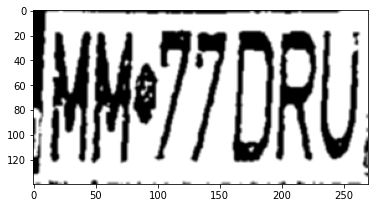

In [ ]:
gr = cv2.cvtColor(img_transformed, cv2.COLOR_BGR2GRAY)
th = 255 - cv2.threshold(gr, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Blur and perform text extraction
th = cv2.GaussianBlur(th, (3,3), 0)
data = pytesseract.image_to_string(th, lang='eng', config='--psm 6')


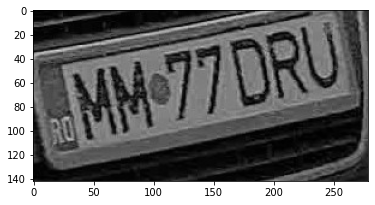

In [ ]:
gray_img = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)
plt.imshow(cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB))

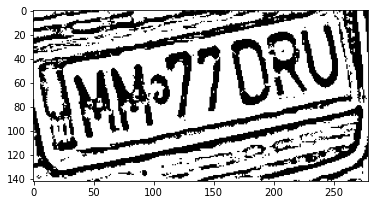

In [ ]:

img_median_blur = cv2.medianBlur(gray_img,9)

ret,th1 = cv2.threshold(img_median_blur,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img_median_blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img_median_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img_median_blur, th1, th2, th3]

plt.imshow(cv2.cvtColor(th3, cv2.COLOR_BGR2RGB))


In [ ]:
reader = easyocr.Reader(['en'])
result = reader.readtext(th3)
result

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[151.91541525424563, 15.244744067831698],
   [258.32619370868906, -3.4015055385544137],
   [268.08458474575434, 74.7552559321683],
   [161.67380629131094, 94.40150553855442]],
  'DRu',
  0.15278078615665436),
 ([[-2.9945899323007117, 39.22380429787686],
   [168.77034749713945, 20.458887826347077],
   [171.9945899323007, 100.77619570212313],
   [-0.7703474971394453, 119.54111217365292]],
  '414|417',
  0.00955735333263874),
 ([[195.00992561958003, 107.800992561958],
   [253.77499215360348, 94.07836945870588],
   [256.99007438041997, 109.199007438042],
   [198.22500784639652, 122.92163054129412]],
  'a_~:',
  4.2607440263964236e-05)]